In [167]:
# import module

import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
import pandas as pd

In [168]:
cgs_mp = 9.10938291e-28
cgs_me = 9.10938291e-28 
cgs_xmh =  cgs_mp + cgs_me
yHe = 9.7222222e-2 
mu = (1.e0+4.e0*yHe)*cgs_xmh
pc = 3.0856775814671916*10**18 #cm
solar_mass = 1.989*10**33 #g

In [169]:
def get_data(filename):
  d = {}
  with h5py.File(filename, "r") as data:
    data_list = list(data)
    for ls in data_list:
      d[ls] = data[ls][()]
  return d

In [170]:
d = get_data('C:/Users/kotor/StarGen/datasets/data_ppp/cb1000.h5')

hx = d['space1']
hy = d['space2']
hz = d['space3']

nH = d['nH']
rho = nH * mu
m = rho * (hx*pc)**3 / solar_mass

print('max m:', np.max(m))
print('min m:', np.min(m))
print('mean m:', np.mean(m))
print('median m:', np.median(m))
print('std m:', np.std(m))
print('sum m:', np.sum(m))

max m: 0.6552333182904154
min m: 2.4170535541687433e-06
mean m: 0.003982158417990253
median m: 2.553643709733843e-05
std m: 0.016893254733730496
sum m: 1043.898936325637


<>:27: SyntaxWarning:

invalid escape sequence '\o'

<>:27: SyntaxWarning:

invalid escape sequence '\o'

C:\Users\kotor\AppData\Local\Temp\ipykernel_16532\1893202649.py:27: SyntaxWarning:

invalid escape sequence '\o'



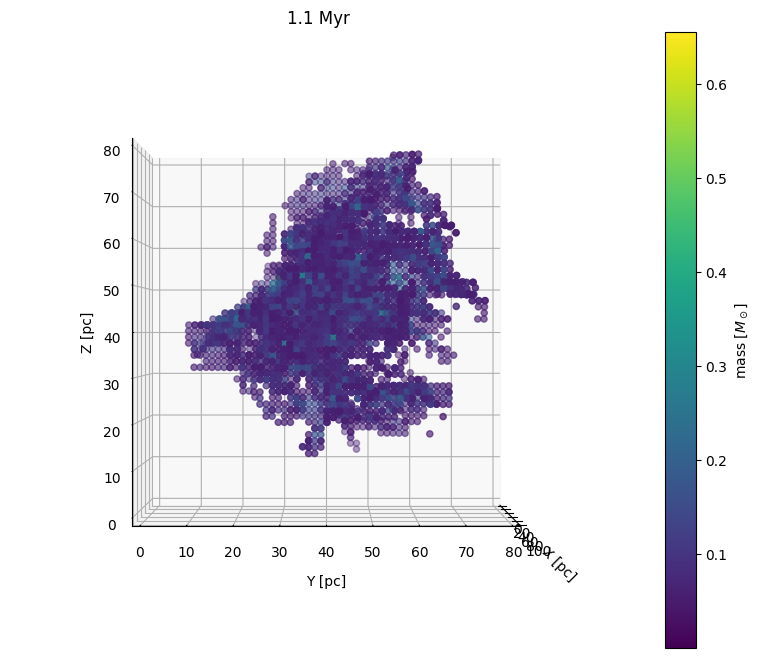

In [171]:
# make 3D map

shape = m.shape
gas_mass = m.reshape(-1)
colormap = plt.get_cmap('viridis')
norm = plt.Normalize(gas_mass.min(), gas_mass.max())

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

x_coords = np.repeat(np.arange(shape[0]), shape[1]*shape[2]) * hx
y_coords = np.tile(np.repeat(np.arange(shape[1]), shape[2]), shape[0]) * hy
z_coords = np.tile(np.arange(shape[2]), shape[0]*shape[1]) * hz

threshold = 0.05
mask= gas_mass > threshold

x_filtered = x_coords[mask]
y_filtered = y_coords[mask]
z_filtered = z_coords[mask]
gas_mass_filtered = gas_mass[mask]

scatter = ax.scatter(x_filtered, z_filtered, y_filtered, c=gas_mass_filtered, cmap=colormap, norm=norm)  

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('mass [$M_\odot$]')

ax.set_xlim3d(0, 100)
ax.set_ylim3d(0, 80)
ax.set_zlim3d(0, 80)

ax.view_init(0, 0)

plt.title("1.1 Myr")

X = ax.set_xlabel('X [pc]', labelpad=10)
Y = ax.set_ylabel('Y [pc]', labelpad=10)
Z = ax.set_zlabel('Z [pc]', labelpad=4)

In [172]:
# compute dendrogram

min_value = 5 * np.std(m)
min_delta = np.std(m)
min_npix = 50

dendro = Dendrogram.compute(m, min_value=min_value, min_delta=min_delta, min_npix=min_npix)

In [173]:
# make feature list

leaf_indices = [i for i, structure in enumerate(dendro) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro) if structure.is_branch]

leaf_npix, branch_npix = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix() 
    leaf_npix.append(npix)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix()
    branch_npix.append(npix)    
leaf_sizes = np.array(leaf_npix) * hx * hy * hz
branch_sizes = np.array(branch_npix) * hx * hy * hz

mass_per_leaf, mass_per_branch = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    leaf_mass = np.sum(m[indices])
    mass_per_leaf.append(leaf_mass)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    branch_mass = np.sum(m[indices])
    mass_per_branch.append(branch_mass)
mass_per_leaf = np.array(mass_per_leaf)
mass_per_branch = np.array(mass_per_branch)

x_peak, y_peak, z_peak, peak_value = [], [], [], []
for s in dendro.leaves:
    x_ch, y_ch, z_ch = s.get_peak()[0]
    value = s.get_peak()[1]
    x_peak.append(round(float(x_ch), 6) * hx)
    y_peak.append(round(float(y_ch), 6) * hy)
    z_peak.append(round(float(z_ch), 6) * hz)
    peak_value.append(round(float(value), 6))

leaf_radius = np.cbrt(3 * (np.array(leaf_sizes)) / (4 * np.pi)) 
branch_radius = np.cbrt(3 * (np.array(branch_sizes)) / (4 * np.pi))

leaf_feature = pd.DataFrame({
    'id':leaf_indices, 
    'leaf_size [pc^2]':leaf_sizes, 
    'leaf_mass [solar mass]':mass_per_leaf,
    'X_peak':x_peak, 
    'Y_peak':z_peak,
    'Z_peak':y_peak, 
    'peak_value [solar mass]':peak_value,
    'leaf_radius [pc]':leaf_radius,
    'fwhm [km/s]':'',
    'virial_parameter':''})
branch_feature = pd.DataFrame({
    'id':branch_indices, 
    'branch_size [pc^2]':branch_sizes, 
    'branch_mass [solar mass]':mass_per_branch,
    'branch_radius [pc]':branch_radius,
    'fwhm [km/s]':'',
    'virial_parameter':''})

leaf_size_ave = np.sum(leaf_sizes) / len(leaf_indices)
branch_size_ave = np.sum(branch_sizes) / len(branch_indices)
leaf_mass_ave = np.sum(mass_per_leaf) / len(leaf_indices)
branch_mass_ave = np.sum(mass_per_branch) / len(branch_indices)

display(leaf_feature)
print('leaf size average:', leaf_size_ave)
print('leaf mass average:', leaf_mass_ave)
#print('leaf virial parameter average:', leaf_vir_ave)
display(branch_feature)
print('branch size average:', branch_size_ave)
print('branch mass average:', branch_mass_ave)
#print('branch virial parameter average:', branch_vir_ave)


,id,leaf_size [pc^2],leaf_mass [solar mass],X_peak,Y_peak,Z_peak,peak_value [solar mass],leaf_radius [pc],fwhm [km/s],virial_parameter
0,1,2103.500018,120.402689,20.764160,33.222656,52.602539,0.459870,7.948490,,
1,5,164.460279,12.652307,23.532715,20.764160,45.681152,0.443534,3.398788,,
2,6,135.281842,10.559287,29.069824,29.069824,52.602539,0.576747,3.184566,,
3,7,159.155109,10.384033,29.069824,34.606934,31.838379,0.472527,3.361842,,
4,8,389.930016,24.073335,33.222656,52.602539,45.681152,0.345695,4.532099,,
5,9,225.469737,14.902948,34.606934,42.912598,53.986816,0.444133,3.775721,,
6,10,246.690418,13.280899,47.065430,44.296875,30.454102,0.452848,3.890642,,
7,11,310.352462,16.187772,49.833984,42.912598,45.681152,0.357679,4.200060,,
8,12,299.742121,17.258482,52.602539,31.838379,45.681152,0.655233,4.151640,,
9,13,185.680960,10.419883,63.676758,44.296875,56.755371,0.479088,3.539101,,


leaf size average: 422.02629619423533
leaf mass average: 25.01216343354455


,id,branch_size [pc^2],branch_mass [solar mass],branch_radius [pc],fwhm [km/s],virial_parameter
0,0,2366.105947,133.944824,8.266377,,
1,2,135.281842,7.443260,3.184566,,
2,3,1352.818423,82.138790,6.860940,,
3,4,790.470373,50.916860,5.735866,,


branch size average: 1161.1691461912415
branch mass average: 68.61093340312256


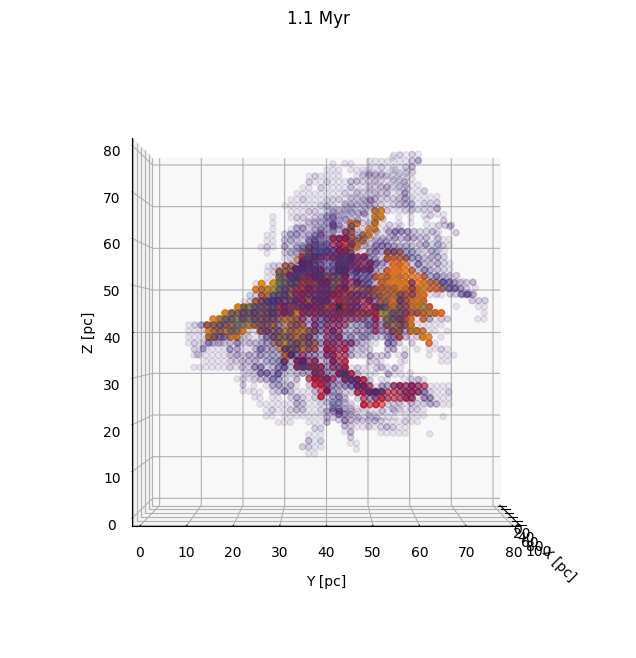

In [180]:
# plot the contour

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

for i, structure_index in enumerate(leaf_indices):
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.scatter(indices[0] * hx, indices[2] * hy, indices[1] * hz, color='red', alpha=0.5)    
for j, structure_index in enumerate(branch_indices):
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.scatter(indices[0] * hx, indices[2] * hy, indices[1] * hz, color='orange', alpha=0.5)

ax.scatter(leaf_feature['X_peak'], leaf_feature['Y_peak'], leaf_feature['Z_peak'], marker='x', color='black')

scatter = ax.scatter(x_filtered, z_filtered, y_filtered, c=gas_mass_filtered, cmap=colormap, norm=norm, alpha=0.1)  

ax.set_xlim3d(0, 100)
ax.set_ylim3d(0, 80)
ax.set_zlim3d(0, 80)

ax.view_init(0, 0)

plt.title("1.1 Myr")

X = ax.set_xlabel('X [pc]', labelpad=10)
Y = ax.set_ylabel('Y [pc]', labelpad=10)
Z = ax.set_zlabel('Z [pc]', labelpad=3)

In [175]:
# plot by plotly

fig = px.scatter_3d(leaf_feature, x='X_peak', y='Y_peak', z='Z_peak')

# Leaf structures
for i, leaf_structure_index in enumerate(leaf_indices):
    leaf_structure = dendro[leaf_structure_index]
    leaf_mask = leaf_structure.get_mask()
    leaf_mask_indices = np.where(leaf_mask)
    mesh_leaf = go.Mesh3d(x=leaf_mask_indices[0] * hx, 
                          y=leaf_mask_indices[2] * hy, 
                          z=leaf_mask_indices[1] * hz, 
                          opacity=0.3,
                          color='red',
                          name=f'Leaf {i + 1} - Surface')
    fig.add_trace(mesh_leaf)

# Branch structures
for j, branch_structure_index in enumerate(branch_indices):
    branch_structure = dendro[branch_structure_index]
    branch_mask = branch_structure.get_mask()
    branch_mask_indices = np.where(branch_mask)
    mesh_branch = go.Mesh3d(x=branch_mask_indices[0] * hx, 
                            y=branch_mask_indices[2] * hy, 
                            z=branch_mask_indices[1] * hz,
                            opacity=0.1, 
                            color='orange',
                            name=f'Branch {j + 1} - Surface')
    fig.add_trace(mesh_branch)

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X [pc]', range=[0, 100]),
        yaxis=dict(title='Y [pc]', range=[0, 80]),
        zaxis=dict(title='Z [pc]', range=[0, 80]),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Structure Contours in 3D with Mesh Surface',
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True)
